In [38]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from scipy.sparse import diags
from numba import njit

from time import time 
from tqdm.notebook import trange

# Diffusion with reflecting and absorbing boundaries

We implement the handling of the boundary by augmenting the solver. After every timestep, it applies a boundary function, that somehow transforms those particles that have crossed the boundary.

In [40]:
# An SDE solver

def EM(X, t, dt, a, b, dW=None):
    # Euler-Maruyama method, with drift a(X, t) and diffusion b(X, t)
    # Unless provided, generate random dW, Gaussian with mean=0 and variance=dt
    # and the correct number of elements
    if dW is None:
        dW = np.random.normal(loc=0, scale=np.sqrt(dt), size=X.shape)
    # Calculate and return next value
    return X + a(X, t)*dt + b(X, t)*dW


# This version of the solver takes an additional argument:
# a function that implements the desired boundary behaviour 
def solve_SDE(X0, tmax, dt, a, b, solver, boundary=None, W=None):
    # A simple solve function (assumes dt evenly divides tmax)
    # Calculate number of timsteps (including 0 and tmax)
    Nt = int(tmax/dt) + 1
    # If X0 is not an array, turn it into a 1-element array
    if not isinstance(X0, np.ndarray):
        X0 = np.array([X0])
    # Arrays to track solution
    X = np.zeros((Nt, *X0.shape))
    X[0,:] = X0
    t = 0
    for n in trange(1, Nt):
        # Call solver, with pre-computed W if available
        if W is None:
            X[n,:] = solver(X[n-1,:], t, dt, a, b)
        else:
            # Obtain increment from pre-computed Wt
            dW = W[n] - W[n-1]
            X[n,:] = solver(X[n-1,:], t, dt, a, b, dW=dW)
        
        # If provided, apply the function that implements behaviour at the boundary
        if boundary is not None:
            X[n,:] = boundary(X[n,:], mask=-999)
            
        t += dt
    return X

# Function that implements reflecting boundary at X=0
def reflect(X, mask=None):
    return np.abs(X)

# Function that implements absorbing boundary at X=0
def absorb(X, mask=None):
    if mask is None:
        # Here we return only those elements were X is larger than 0
        # thus making the array shorter
        return X[X>=0]
    else:
        # Here we set the elements of X smaller than 0 to some fixed value
        # thus keeping the array the same length
        return np.where(X >= 0, X, mask)


# Gaussian pdf, for use in comparison with analytical solutions
def gaussian(x, mu, sigma):
    return np.exp(-0.5*(x-mu)**2/sigma**2) / (np.sqrt(2*np.pi)*sigma)

## Reflecting boundary

Points to note about the reflecting case:
* The observed distribution of particle positions is equal to the analytical distribution indepent of the timestep (only true in the case with constant diffusivity). 
* The derivative of the density is zero at the boundary, as we discussed in relation to the zero-flux boundary condition for the diffusion PDE solver (Neumann boundary condition, with $\partial p/\partial x=0$).

  0%|          | 0/10 [00:00<?, ?it/s]

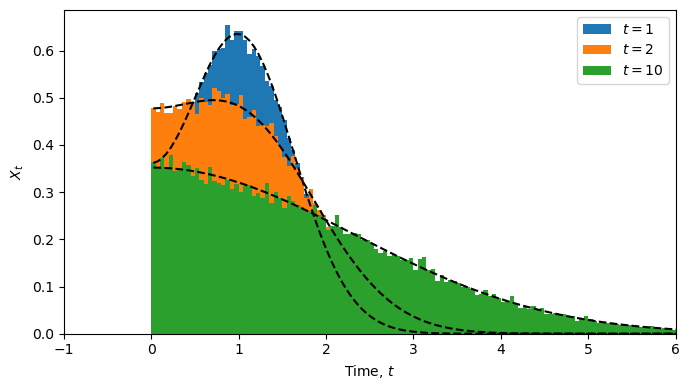

In [58]:
v = 0.0
K = 0.2

# Implementing a and b as functions, even though they are constant here,
# for consistency with the general solver
def a(X, t):
    return v

def b(X, t):
    return np.sqrt(2*K)

# Several initial values leads to several solutions
Np = 50000
X0 = 1.0
# Integration time
tmax = 10
# timestep
dt = 1

# Passing the boundary function implementing reflecting boundary
X = solve_SDE(X0*np.ones(Np), tmax, dt, a, b, EM, boundary=reflect)

times = dt*np.arange(X.shape[0])
bins, dx =np.linspace(0, 10, 201, retstep=True) # bins
mids=bins[:-1] + (bins[1]-bins[0])/2 # midpoints of the bins

# Plot solutions at different times
fig = plt.figure(figsize = (7, 4))
for t in [1, 2, 10]:
    # Find closest time we have solutions for
    it = np.argmin(np.abs(t - times))
    plt.hist(X[it,:], bins=bins, label=f'$t={times[it]}$', weights=np.ones(Np)/(dx*Np))
    
    # Analytical solution with reflecting boundary:
    # Sum of a Gaussian and a mirror image Gaussian
    mu = X0
    sigma = np.sqrt(2*K*times[it])
    plt.plot(mids, gaussian(mids, mu, sigma) + gaussian(mids, -mu, sigma), '--', c='k')
    
plt.xlabel('Time, $t$')
plt.ylabel('$X_t$')
plt.xlim(-1, 6)
plt.legend()
plt.tight_layout()

## Absorbing boundary

Points to note about the absorbing boundary case:
* Observed distribution of solutions of the SDE depends on timestep (with long timesteps, $\Delta t$, we do not absorb particles that are inside the boundary at both $t$ and $t + \Delta t$, but would have been outside in between).
* The value of the density at the boundary is zero, which is one way to implement absorbing boundary conditions in the diffusion PDE (Dirichlet boundary condition, with $p=0$).

  0%|          | 0/1000 [00:00<?, ?it/s]

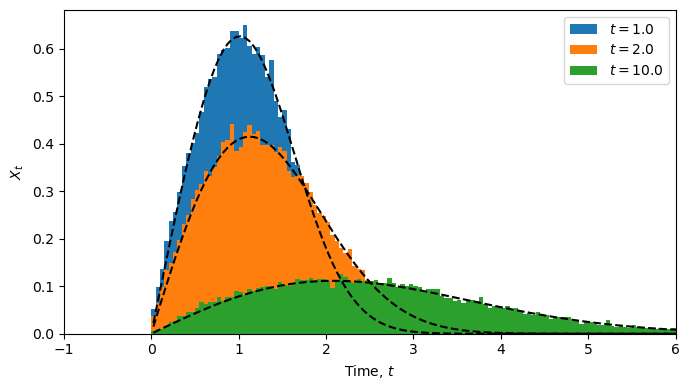

In [61]:
v = 0.0
K = 0.2

# Implementing a and b as functions, even though they are constant here,
# for consistency with the general solver
def a(X, t):
    return v

def b(X, t):
    return np.sqrt(2*K)

# Several initial values leads to several solutions
Np = 50000
X0 = 1.0
# Integration time
tmax = 10
# timestep
dt = 0.01

# Passing the boundary function implementing absorbing boundary
X = solve_SDE(X0*np.ones(Np), tmax, dt, a, b, EM, boundary=absorb)

times = dt*np.arange(X.shape[0])
bins, dx =np.linspace(0, 10, 201, retstep=True) # bins
mids=bins[:-1] + (bins[1]-bins[0])/2 # midpoints of the bins

# Plot solutions at different times
fig = plt.figure(figsize = (7, 4))
for t in [1, 2, 10]:
    # Find closest time we have solutions for
    it = np.argmin(np.abs(t - times))
    plt.hist(X[it,:], bins=bins, label=f'$t={times[it]}$', weights=np.ones(Np)/(dx*Np))
    
    # Analytical solution with absorbing boundary:
    # Difference of a Gaussian and a mirror image Gaussian
    mu = X0
    sigma = np.sqrt(2*K*times[it])
    plt.plot(mids, gaussian(mids, mu, sigma) - gaussian(mids, -mu, sigma), '--', c='k')

plt.xlabel('Time, $t$')
plt.ylabel('$X_t$')
plt.xlim(-1, 6)
plt.legend()
plt.tight_layout()

# References

Kloeden & Platen (1992), _Numerical Solution of Stochastic Differential Equations_. https://link.springer.com/book/10.1007/978-3-662-12616-5